# Задание

Определить оптимальное число тем для датасета `./data/The Guardian_example_1.csv` и привести топ-30 слов (наиболее вероятностные слова) по каждой теме из списка оптимальных слов.

# Настройки/Импорты

In [1]:
DATA_DIR = "./data/" # путь до папки с данными
MODELS_DIR = "./models/" # путь до папки с моделями
EMBEDDING_DIR = "./embeddings/" # путь до папки с эмбеддингами слов

RANDOM_STATE = 42 # число для задания случайности
CLEANING_VARS = ["all"] # варианты очистки текста
ADD_STOP_WORDS = ["say", "said", "wa", "u"] # дополнительные стоп-слова

MAX_TOPICS = 100 # максимальное число тем

In [2]:
import sys # для работы с системой

sys.path.append(f"{MODELS_DIR}GLDAW/") # путь до файлов с моделью GLDAW для Topic Modeling (TM)
# !{sys.executable} -m pip install <module_name> # установка дополнительных модулей

In [3]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом
import math # для математических операций
import psutil # для просмотра числа потоков на cpu
from pandarallel import pandarallel # для параллельного запуска кода на cpu
from tqdm import tqdm # для отслеживания прогресса

import gibbslda # GLDAW модель для Topic Modeling (TM)

from nltk.stem import WordNetLemmatizer # лемматизатор (для английского)
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # для токенизации строки

import matplotlib.pyplot as plt # для построения графиков
from wordcloud import WordCloud # для построения изображения с самыми часто встречаемыми словами (помогает в определении дополнительных стоп-слов)
import time # для отслеживания времени выполнения

In [4]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False)) # число доступных потоков

Количество доступных потоков:  4


# Универсальные вспомогательные функции

In [5]:
pandarallel.initialize(progress_bar=True) # запуск в параллельном режиме (с отображением прогресса выполнения)

def clear_data(df: pd.DataFrame, var, columns=["text"], stop_words=[]) -> pd.DataFrame:
    """
    Универсальная параллельная функция для очистки датасета (лишние пробелы можно не удалять, так как word_tokenize их сам уберёт).\n
    Parameters:
        * df: рассматриваемый датасет
        * var: тип очистки
        * columns: столбцы в датасете, что будут очищаться
        * stop_words: какие стоп-слова использовать\n
    Returns:
        * pd.DataFrame: датасет с очищенными столбцами columns
    """
    # импортируем, так как потоки их перестанут видеть
    import re
    # import pymorphy3
    from nltk.tokenize import word_tokenize


    # morph = pymorphy3.MorphAnalyzer() # объект для лемматизации слов
    lemmatizer = WordNetLemmatizer() # объект для лемматизации слов


    for column in columns: # идём по переданным столбцам для обработки
        df[column] = df[column].parallel_apply(lambda text: text.lower()) # приводим к нижнему регистру

        if var in ["trash", "all"]:
            # df[column] = df[column].parallel_apply(lambda text: re.sub('\[\[\w*d*\|', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])
            # df[column] = df[column].parallel_apply(lambda text: re.sub(']', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])

            # df[column] = df[column].parallel_apply(lambda text: re.sub('@\S*', '', text)) # убираем тегирование (например @Soloviev)

            df[column] = df[column].parallel_apply(lambda text: re.sub('<.*?>', '', text)) # убираем html элементы

            df[column] = df[column].parallel_apply(lambda text: re.sub("http\S*", ' ', text)) # убираем ссылки (например https://t.co/KN1g4AWFIb)


        if var in ["punctuation", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub(r"[,.…?:;¦/\\!@#$#—–+=ツ►๑۞۩•«»“”˜°*`\"'’™)(<>\[\]%$&]", '', text)) # удаляем различную пунктуацию
            df[column] = df[column].parallel_apply(lambda text: re.sub("-", ' ', text)) # заменяем тире на пробел


        if var in ["digits", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub('\d', '', text)) # удаляем цифры


        df[column] = df[column].parallel_apply(lambda text: word_tokenize(text)) # разбиваем текст на токены
        # df[column] = df[column].parallel_apply(lambda text: [morph.parse(word)[0].normal_form for word in text]) # приводим слова к нормальной форме (если она у них есть, иначе они остаются без изменения)
        df[column] = df[column].parallel_apply(lambda text: [lemmatizer.lemmatize(word) for word in text]) # лемматизируем слова

        if var in ["stop_words", "all"]:
            df[column] = df[column].parallel_apply(lambda text: [word for word in text if word not in stop_words]) # удаляем стоп-слова

        df[column] = df[column].parallel_apply(lambda text: ' '.join(text)) # собираем токены обратно в строку
        df[column] = df[column].astype('string') # приводим колонку к типу строки (чтобы у записей не было начальных и конечных кавычек)

        # df = df[df[column].notnull()] # оставляем те строки, у которых рассматриваемый столбец имеет значение
        df = df[df[column] != ""] # оставляем те строки, данные в которых не занулились

    df.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True и перезаписываем существующий датасет)
    return df # возвращаем обработанный датасет

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [6]:
def read_embedding_file(file: str, words, skip_first: bool, encoding: str="utf-8") -> dict:
    """
    Вспомогательная функция для чтения файла формате .vec с эмбеддингами.\n
    Parameters:
        * file: путь до файла с эмбеддингами
        * words: слова, для которых нужны эмбеддинги (если не указан — будут загружены все эмбеддинги из файла)
        * skip_first: пропускать ли первую строку (на случай, если она не содержит эмбеддинги)
        * encoding: тип кодировки\n
    Returns:
        * dict: словарь эмбеддингов
    """
    vectors = {} # словарь под эмбеддинги

    with open(file, "r", encoding=encoding) as f: # открываем файл по пути file с кодировкой encoding для чтения ("r") 
        if skip_first:
            _ = f.readline() # считываем строку "в никуда"

        for line in tqdm(f): # идём по оставшимся строкам в файле
            tokens = line.split() # получаем токены строки в виде (str, float, float, float, ...)
            if tokens[0] in words and len(words): # если первый токен (слово) в списке необходимых нам слов (и этот список не пуст)
                vectors[tokens[0]] = map(float, tokens[1:]) # в словарь под tokens[0] (слово) записываем значение его вектора, при этом сконвертировав их в float (запишется объект map)
                vectors[tokens[0]] = list(vectors[tokens[0]]) # преобразовываем результат функции map в list

    return vectors # возвращаем словарь эмбеддингов

In [7]:
def save_embeddings(file: str, embeddings: dict) -> None:
    """
    Вспомогательная функция для сохранения готовых эмбеддингов в файл в формате для word2vec.\n
    Parameters:
        * file: путь до файла, куда будут сохраняться эмбеддинги
        * embeddings: эмбеддинги слов в виде словаря, где ключ — слово, по которому расположен его вектор\n
    Returns:
        * None
    """
    with open(file, "w") as f: # открываем файл по пути file для записи ("w")
        for word in embeddings.keys(): # идём по словам
            vector = map(str, embeddings[word]) # конвертируем все значения float в строки (запишется объект map)
            vector = list(vector) # преобразовываем результат функции map в list
            f.write(f"{word} {' '.join(vector)}\n") # записываем строку в файл в виде (str float float float ...)

# Предобработка датасета

In [8]:
dataset = pd.read_csv(DATA_DIR + "The Guardian_example_1.csv", sep=";", encoding="ANSI") # считывание данных в формате csv, разделённых с помощью символа sep и закодированных в encoding (можно проверить с помощью Notepad++, тип кодировки будет справа снизу)
dataset

,Section,Headline,Content,Publication Date,URL
0,World news,Russia expels Dutch journalist Tom Vennink,Russia has expelled a Dutch reporter his news...,2021-11-04 11:11:36,https://www.theguardian.com/world/2021/nov/04/...
1,Science,Can you solve it? From Russia with logic,The largest and most important event in the ma...,2021-12-13 07:10:01,https://www.theguardian.com/science/2021/dec/1...
2,Science,Did you solve it? From Russia with logic,Earlier today I set you three questions from a...,2021-12-13 17:00:24,https://www.theguardian.com/science/2021/dec/1...
3,Politics,Labour challenges Tories over checks on Russia...,Labour has asked the Conservatives what checks...,2021-11-17 13:04:29,https://www.theguardian.com/politics/2021/nov/...
4,World news,Russia holds high-profile Afghanistan talks wi...,Russia has hosted the most high-profile intern...,2021-10-20 17:09:40,https://www.theguardian.com/world/2021/oct/20/...
...,...,...,...,...,...
2548,US news,Trump impeachment trial to begin week of 8 Feb...,From me and Joan E Greve: Senate leader Chuck ...,2021-01-23 01:08:03,https://www.theguardian.com/us-news/live/2021/...
2549,World news,France's Covid toll passes 70 000 – as it happ...,We are closing this blog now and starting fre...,2021-01-17 00:53:34,https://www.theguardian.com/world/live/2021/ja...
2550,World news,EU 'to stop short of vaccine export ban' – as ...,We’ve launched a new blog at the link below – ...,2021-01-26 23:34:50,https://www.theguardian.com/world/live/2021/ja...
2551,World news,Pandemic death toll exceeds 2 million people w...,This liveblog has now closed. Our coverage of ...,2021-01-15 21:30:06,https://www.theguardian.com/world/live/2021/ja...


Изначальное распределение тем в датасете.

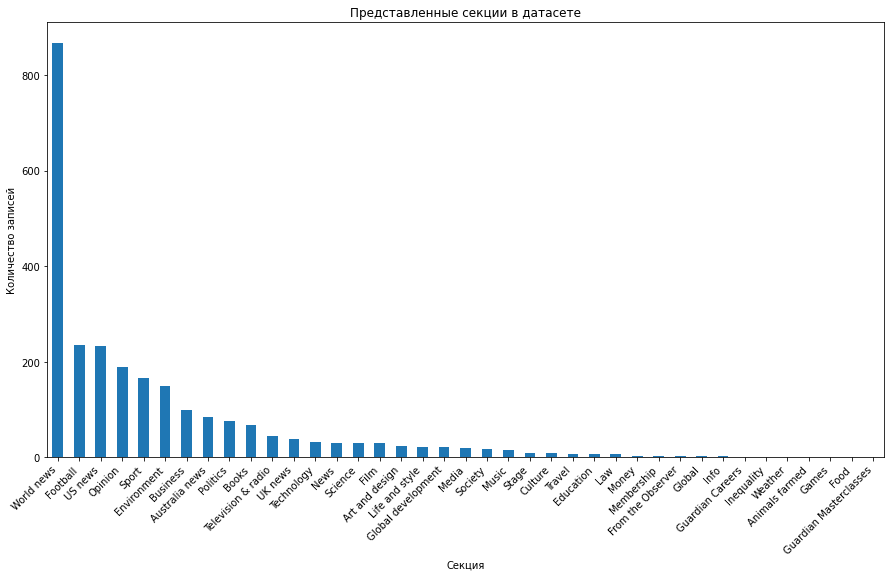

In [9]:
plt.figure(figsize=(15,8)) # задание размера фигуры
dataset["Section"].value_counts().plot.bar() # построение столбчатой диаграммы по данным
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Представленные секции в датасете") # название фигуры
plt.xlabel("Секция") # подпись по оси x
plt.ylabel("Количество записей") # подпись по оси y
plt.show() # показ фигуры

## Очистка датасета

Стоп-слова для удаления.

In [10]:
stop_words = stopwords.words('english') # список стоп-слов для английского языка
for add_stop in ADD_STOP_WORDS: # идём по дополнительным стоп-словам
    stop_words.append(add_stop) # добавляем стоп-слово
stop_words[:10] # первые 10 стоп-слов для английского языка

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Очищаем датасет.

In [11]:
for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    dataset_cleared = clear_data(dataset.copy(), var, ["Content"], stop_words) # проводим очистку датасета
    dataset_cleared.to_csv(DATA_DIR + f"data_{var}.csv", sep=";", index=False) # сохраняем полученный датасет (index=False — без сохранения индексов)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [01:17<00:00, 77.41s/it]


## Отображение самых частых слов в датасете

Данный шаг помогает определить дополнительные, неявные стоп-слова.

In [12]:
dataset_cleared = pd.read_csv(DATA_DIR + "data_all.csv",  sep=";", encoding="utf-8", index_col=False) # считывание данных в формате csv, разделённых с помощью символа sep, закодированных в encoding и без колонки индексов в файле (index_col=False)
dataset_cleared

,Section,Headline,Content,Publication Date,URL
0,World news,Russia expels Dutch journalist Tom Vennink,russia ha expelled dutch reporter newspaper ha...,2021-11-04 11:11:36,https://www.theguardian.com/world/2021/nov/04/...
1,Science,Can you solve it? From Russia with logic,largest important event mathematical calendar ...,2021-12-13 07:10:01,https://www.theguardian.com/science/2021/dec/1...
2,Science,Did you solve it? From Russia with logic,earlier today set three question russian math ...,2021-12-13 17:00:24,https://www.theguardian.com/science/2021/dec/1...
3,Politics,Labour challenges Tories over checks on Russia...,labour ha asked conservative check party ha ma...,2021-11-17 13:04:29,https://www.theguardian.com/politics/2021/nov/...
4,World news,Russia holds high-profile Afghanistan talks wi...,russia ha hosted high profile international ta...,2021-10-20 17:09:40,https://www.theguardian.com/world/2021/oct/20/...
...,...,...,...,...,...
2548,US news,Trump impeachment trial to begin week of 8 Feb...,joan e greve senate leader chuck schumer ha an...,2021-01-23 01:08:03,https://www.theguardian.com/us-news/live/2021/...
2549,World news,France's Covid toll passes 70 000 – as it happ...,closing blog starting fresh australia health m...,2021-01-17 00:53:34,https://www.theguardian.com/world/live/2021/ja...
2550,World news,EU 'to stop short of vaccine export ban' – as ...,weve launched new blog link head latest hotel ...,2021-01-26 23:34:50,https://www.theguardian.com/world/live/2021/ja...
2551,World news,Pandemic death toll exceeds 2 million people w...,liveblog ha closed coverage coronavirus pandem...,2021-01-15 21:30:06,https://www.theguardian.com/world/live/2021/ja...


Вывод самых частых слов в документах.

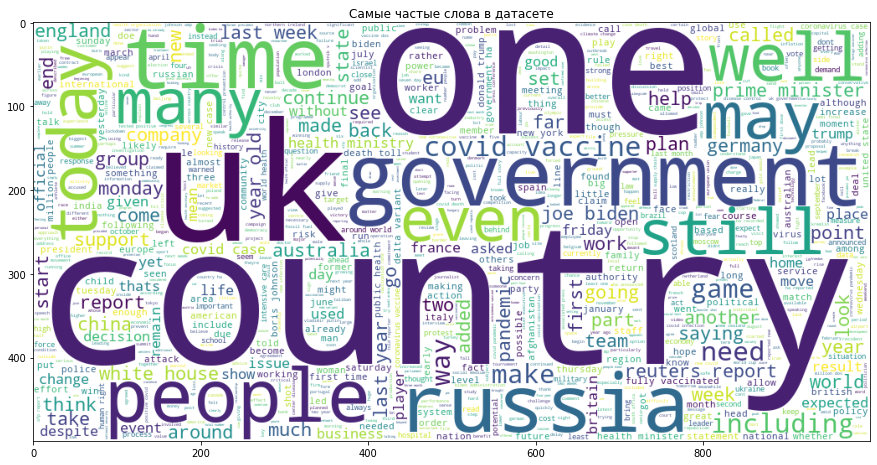

In [13]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=RANDOM_STATE) # создание WordCloud объекта
wordcloud.generate(" ".join(dataset_cleared["Content"])) # отправляем в WordCloud весь текст из датасета

plt.figure(figsize=(15,10)) # задание размера фигуры
plt.imshow(wordcloud) # отображение картинки
plt.title("Самые частые слова в датасете") # название фигуры
plt.show() # показ фигуры

## Эмбеддинги

Для тематического моделирования возьмём только столбец "Content" датасета, так как он содержит основную информацию, и разобьём текста (***документы***) в нём на токены (***слова***).

In [7]:
dataset_cleared = pd.read_csv(DATA_DIR + "data_all.csv", sep=";", encoding="utf-8", index_col=False) # считывание данных в формате csv, разделённых с помощью символа sep, закодированных в encoding и без колонки индексов в файле (index_col=False)
corpus = [doc.split() for doc in dataset_cleared["Content"]] # берём значения только одной колонки, содержащей текст постов, и разбиваем каждую запись в ней (документ) на токены (отдельные слова) по пробелу
print(corpus[:2]) # пример содержимого первых двух документов

[['russia', 'ha', 'expelled', 'dutch', 'reporter', 'newspaper', 'ha', 'moscow', 'continues', 'crackdown', 'domestic', 'foreign', 'journalist', 'country', 'de', 'volkskrant', 'journalist', 'tom', 'vennink', 'visa', 'revoked', 'given', 'three', 'day', 'leave', 'country', 'difficulty', 'renewing', 'journalist', 'accreditation', 'expulsion', 'second', 'foreign', 'journalist', 'recent', 'month', 'following', 'russia', 'decision', 'august', 'ban', 'bbc', 'reporter', 'sarah', 'rainsford', 'country', 'security', 'threat', 'formally', 'vennink', 'targeted', 'russia', 'interior', 'ministry', 'two', 'minor', 'administrative', 'violation', 'including', 'failure', 'register', 'temporary', 'address', 'dating', 'back', 'increasingly', 'bitter', 'relationship', 'moscow', 'amsterdam', 'appears', 'played', 'role', 'decision', 'vennink', 'respected', 'foreign', 'correspondent', 'ha', 'reported', 'russia', 'since', 'expulsion', 'came', 'surprise', 'russian', 'journalist', 'face', 'serious', 'obstacle', 'w

Оставим эмбеддинги только тех слов, что встречались в датасете. Для этого сначала найдём все уникальные токены в корпусе.

In [8]:
unique_words = set() # set для уникальных слов

for doc in corpus: # идём по текстам (документам) в датасете 
    for word in doc: # идём по словам в документе
        unique_words.add(word) # добавляем слово в set (если оно там уже есть, то ничего не произойдёт)

print(f"Число слов в датасете: {len(unique_words)}") # вывод числа слов в датасете

Число слов в датасете: 64705


Загружаем эмбеддинги слов в корпусе.

In [9]:
vectors = read_embedding_file(f"{EMBEDDING_DIR}wiki-news-300d-1M-subword.vec", words=unique_words, skip_first=True) # считываем эмбеддинги для слов в датасете
pd.DataFrame(vectors) # как выглядят эмбеддинги в виде pd.DataFrame (на самом деле они хранятся в виде словаря, где ключ — слово и по нему располагается его вектор)

262it [00:00, 2425.97it/s]

999994it [01:46, 9404.77it/s] 


,one,|,page,also,time,people,like,article,would,talk,...,trapp,dartford,kwik,hippogriffs,umra,empt,pch,bootle,gerson,steinberg
0,0.0104,0.0247,0.0089,-0.0084,-0.0032,0.0089,0.0045,0.0050,-0.0107,0.0212,...,0.0021,0.0029,0.0005,-0.0155,-0.0377,-0.0001,-0.0021,-0.0008,0.0015,0.0007
1,0.0027,0.0284,-0.0544,-0.0032,-0.0722,-0.0051,0.0068,-0.0114,0.0047,-0.0325,...,-0.0164,-0.0274,0.0084,-0.0092,-0.0070,-0.0028,0.0002,-0.0075,-0.0080,-0.0098
2,0.0131,0.0351,0.0387,0.0216,0.0054,0.0078,0.0316,0.0150,0.0067,0.0039,...,0.0041,-0.0122,0.0035,0.0095,0.0036,-0.0026,-0.0000,-0.0023,-0.0080,0.0038
3,-0.0020,0.0565,0.0045,-0.0193,0.0051,0.0004,0.0096,0.0046,0.0066,0.0009,...,0.0134,-0.0045,-0.0041,-0.0010,-0.0183,0.0025,0.0048,0.0272,0.0063,0.0098
4,-0.0282,-0.0541,0.0548,-0.0046,0.0142,-0.0121,-0.0098,0.0234,-0.0017,-0.0031,...,0.0008,-0.0063,-0.0032,-0.0087,0.0060,0.0068,0.0053,-0.0033,0.0015,0.0033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.0019,-0.0401,0.0113,0.0128,0.0275,0.0167,0.0130,-0.0055,-0.0083,-0.0188,...,-0.0269,-0.0099,-0.0089,0.0006,0.0241,-0.0257,0.0060,-0.0090,0.0061,-0.0070
296,0.0250,-0.0019,-0.0072,-0.0005,-0.0083,0.0132,0.0099,0.0037,-0.0095,0.0018,...,0.0120,-0.0074,0.0045,0.0111,0.0433,-0.0224,-0.0001,-0.0068,-0.0004,0.0049
297,0.0195,0.0389,0.0097,0.0086,-0.0151,-0.0107,0.0122,-0.0015,0.0005,-0.0085,...,0.0126,-0.0120,-0.0008,0.0224,0.0096,-0.0205,-0.0145,-0.0054,0.0072,0.0080
298,0.0267,0.0415,0.0053,0.0169,-0.0035,-0.0224,0.0049,-0.0138,-0.0072,0.0002,...,0.0327,-0.0059,0.0082,-0.0213,-0.0007,-0.0042,0.0090,-0.0123,-0.0123,-0.0110


Сохраняем только необходимые эмбеддинги в word2vec формате.

In [17]:
save_embeddings(f"{EMBEDDING_DIR}words_in_docs.txt", vectors) # сохраним эмбеддинги

# Тематическое моделирование

## Определение количества тем

Сначала определим оптимальное число тем в датасете с помощью энтропии Реньи.

Первый подход (медленный):
1) Для каждого возможного числа тем посчитать матрицы Phi — ***Ф*** (word — topic distribution) и Theta — ***Θ*** (topics — docs distribution).
2) Рассчитать получившуюся энтропию Реньи для всех матриц ***Ф***.
3) Выбрать то разбиение, у которого оказалось минимальное значение энтропии Реньи.

Второй подходов (быстрый, его и будем использовать): 
1) Попытаться определить сразу некоторое большое количество тем, например — 100 (получить матрицы ***Ф*** и ***Θ*** для 100 тем).
2) Объединять по две темы из получившиеся списка (как вариант — те, у которых минимальная энтропия Реньи в матрице ***Ф***).
3) Подсчитать получившуюся энтропию Реньи.
4) Перейти к шагу 2, пока тем не останется 2.
5) Выбрать то разбиение, у которого оказалось минимальное значение энтропии Реньи.

### 1) Подготовка модели с получением матриц ***Ф*** и ***Θ*** для 100 тем

Для разбиения будем использовать модель **GLDAW** (GRANULATED Latent Dirichlet Allocation, based on Gibbs sampling with word embeddings), так как она показывала достаточно стабильный результат в других работах (описаны в `./info/topic_modeling`).

In [18]:
model = gibbslda.CGibbsLDA() # GLDAW модель
model

In [19]:
model.SetInputDocs(corpus) # загружаем исходные токенизированные текста в модель

Documents count:  2553
Loading OK     


In [20]:
model.SetParameters(alpha=0.1, beta=0.1, topics=MAX_TOPICS, niters=100, nitersave=100, ldamethod="embeddings", fixtopics=0, granwnd=0, out_dir=f"{DATA_DIR}100_topics/") # задаём параметры для GLDAW
# alpha, beta — параметры для мультиномиального распределения Дирихле
# topics — число тем, что нужно определить среди документов
# niters — число итерация
# nitersave — через сколько итераций сохраняются матрицы Θ и Ф
# ldamethod — метод для LDA, возможные значения:
#   "lda"
#   "islda" - пока не реализован
#   "granulate" - в этом случае надо указать параметр granwnd
#   "embeddings" - модель с эмбедингами (вычисление будет с использованием уже заготовленных векторов слов)
# fixtopics — в данной реализации — фиктивный параметр
# granwnd — размер окна
# out_dir — куда будут сохраняться матрицы Θ и Ф

# Если параметр ldamethod="embeddings", то надо вызвать SetEmbeddings() и указать путь к файлу эмбеддингов и требуемое количество слов
model.SetEmbeddings(f"{EMBEDDING_DIR}words_in_docs.txt", emb_similars=30) # устанавливаем эмбеддинги 
# emb_similars — сколько искать близких векторов

Calculating the Most Similar Words
Done. Words misses =  23768 / 64705


In [21]:
start_time = time.time() # замеряем время, что было при старте

model.StartCalculation() # запуск подсчёта матриц Ф и Θ при заданных параметрах (некоторые слова могут не иметь эмбеддинга)

print(f"Время, затраченное на нахождение {MAX_TOPICS} тем: {time.time() - start_time:.5f} секунд") # выводим затраченное время (в секундах)

Iterations done:  100
    Documents ratio (Theta) =  6
    Words ratio (Phi) =  2
Время, затраченное на нахождение 100 тем: 281.60523 секунд


In [22]:
Ф_columns = ["Word"] # список с столбцами для матрицы Ф, сначала в нём только столбец "Word"
Ф_columns.extend([f"Topic {i+1}" for i in range(MAX_TOPICS)]) # расширяем список столбцов, добавляя элементы "Topic i" из генератора (i+1 чтобы нумерация шла с 1)
Ф = pd.read_csv(f"{DATA_DIR}100_topics/phi100.csv", sep=";", encoding="windows-1251", index_col=False, names=Ф_columns) # считывание данных в формате csv, разделённых с помощью символа sep, закодированных в encoding, без колонки индексов в файле (index_col=False) и с кастомными названиями колонок (names)
Ф # подсчитанная матрица Phi

,Word,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99,Topic 100
0,able,0.00000,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001,0.00001,0.00001,...,0.0,0.0,0.00001,0.00001,0.00106,0.00001,0.00001,0.00000,0.00001,0.00001
1,acceptable,0.00000,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001,0.00001,0.00001,...,0.0,0.0,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001
2,accredit,0.00000,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001,0.00001,0.00001,...,0.0,0.0,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001
3,accreditation,0.00000,0.00001,0.00001,0.00001,0.00005,0.00001,0.00001,0.00001,0.00001,...,0.0,0.0,0.00001,0.00001,0.00001,0.00001,0.00001,0.00009,0.00001,0.00001
4,added,0.00004,0.00001,0.00001,0.00001,0.00019,0.00001,0.00001,0.00001,0.00001,...,0.0,0.0,0.00001,0.00007,0.00001,0.00001,0.00001,0.00079,0.00001,0.00001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64700,thawley,0.00000,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001,0.00001,0.00001,...,0.0,0.0,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001
64701,transportable,0.00000,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001,0.00001,0.00001,...,0.0,0.0,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001
64702,trashy,0.00000,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001,0.00001,0.00001,...,0.0,0.0,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001
64703,vaccinecovid,0.00000,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001,0.00001,0.00001,...,0.0,0.0,0.00001,0.00001,0.00001,0.00001,0.00001,0.00000,0.00001,0.00001


In [23]:
Θ_columns = ["Doc"] # список с столбцами для матрицы Θ, сначала в нём только столбец "Doc"
Θ_columns.extend([f"Topic {i+1}" for i in range(MAX_TOPICS)]) # расширяем список столбцов, добавляя элементы "Topic i" из генератора (i+1 чтобы нумерация шла с 1)
Θ = pd.read_csv(f"{DATA_DIR}100_topics/theta100.csv", sep=";", encoding="windows-1251", index_col=0, names=Θ_columns) # считывание данных в формате csv, разделённых с помощью символа sep, закодированных в encoding, с колонкой индексов в файле (index_col=0 — в качестве индексов будет идти первое значение) и с кастомными названиями колонок (names)
Θ # подсчитанная матрица Theta

,Doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 91,Topic 92,Topic 93,Topic 94,Topic 95,Topic 96,Topic 97,Topic 98,Topic 99,Topic 100
1,russia ha expelled dutch reporter newspaper ha...,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,...,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.51534,0.00027,0.00027
2,largest important event mathematical calendar ...,0.00035,0.00035,0.00035,0.00035,0.00035,0.00035,0.00035,0.00035,0.00035,...,0.00035,0.00035,0.00035,0.00035,0.00035,0.00389,0.00035,0.00035,0.00035,0.00035
3,earlier today set three question russian math ...,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,...,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027,0.00027
4,labour ha asked conservative check party ha ma...,0.00022,0.00022,0.00022,0.00022,0.00022,0.00022,0.00022,0.00022,0.00022,...,0.00022,0.03371,0.00022,0.00022,0.00022,0.00022,0.00022,0.06049,0.00022,0.00022
5,russia ha hosted high profile international ta...,0.00023,0.00023,0.00023,0.00023,0.00023,0.00023,0.00023,0.00023,0.00023,...,0.00023,0.00023,0.00023,0.00023,0.00023,0.00023,0.00023,0.12378,0.00023,0.00023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549,joan e greve senate leader chuck schumer ha an...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003
2550,closing blog starting fresh australia health m...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,...,0.00069,0.00003,0.00036,0.00003,0.00003,0.00003,0.00036,0.00003,0.00003,0.00003
2551,weve launched new blog link head latest hotel ...,0.00003,0.00003,0.00003,0.00003,0.00036,0.00003,0.00003,0.00003,0.00003,...,0.00782,0.00003,0.00133,0.00328,0.00003,0.00003,0.00101,0.00003,0.00003,0.00003
2552,liveblog ha closed coverage coronavirus pandem...,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,0.00003,...,0.00003,0.00003,0.00036,0.00003,0.00003,0.00003,0.00069,0.00103,0.00003,0.00003


### 2-4) Ренормализация (объединение тем, пока их не останется 2, с подсчётом энтропии Реньи)

На этом шаге потребуются только значения из матрицы Phi (***Ф***).

In [24]:
del Ф['Word'] # удаляем ненужный столбец

X = Ф.values # берём только значения в матрице Ф
num_words, num_topics = X.shape # число слов и тем 
print('Число слов: ', num_words)
print('Число тем: ', num_topics)

X[X < 0.00000001] = 0.00000001 # убираем нули, если они есть (чтобы логарифм при подсчёте энтропии Реньи не превратился в -бесконечность)
X

Число слов:  64705
Число тем:  100


array([[1.e-08, 1.e-05, 1.e-05, ..., 1.e-08, 1.e-05, 1.e-05],
       [1.e-08, 1.e-05, 1.e-05, ..., 1.e-08, 1.e-05, 1.e-05],
       [1.e-08, 1.e-05, 1.e-05, ..., 1.e-08, 1.e-05, 1.e-05],
       ...,
       [1.e-08, 1.e-05, 1.e-05, ..., 1.e-08, 1.e-05, 1.e-05],
       [1.e-08, 1.e-05, 1.e-05, ..., 1.e-08, 1.e-05, 1.e-05],
       [1.e-08, 1.e-05, 1.e-05, ..., 1.e-08, 1.e-05, 1.e-05]])

In [25]:
num_words, num_topics = X.shape # число слов и тем изначально
print(f"Количество тем в начале: {num_topics}")

threshold = 1/num_words # порог вероятности слова в теме, выше которого будем считать (если меньше порога — считаем слово незначительным для темы)
min_Renyi = 1000000000 # манимальное значение энтропии Реньи (изначально — заглушка)
opt_topics_count = num_topics # оптимальное число тем (изначально — то, что уже посчитанно)
Density = [] # список под глобальную энтропию Шеннона
Energy = [] # список под глобальную "энергию"

# для каждой темы (чтобы объединять темы с минимальной энтропией Реньи)
# Renyi = [] # список под значения энтропии Реньи для каждой темы
# clusters = [] # список под номера тем
# word_ratio = 0 # сколько слов встречается в теме, у которых вероятность выше порога
# sum_prob = 0 # сумма вероятностей слов, у которых вероятность выше порога у темы
# free_energy = 0 # "свободная энергия" темы
# Renyi_entropy = 0 # значение энтропии Реньи для одной темы

# как верхнее, только для всех тем сразу (для графика)
glob_Renyi = [] # список под значения глобальной энтропии Реньи (по всем темам на каждом решении решении)
glob_clusters = [] # список под рассмотренное число тем
# glob_word_ratio = 0 # сколько слов встречается в корпусе, у которых вероятность выше порога
# glob_sum_prob = 0 # сумма вероятностей слов, у которых вероятность выше порога среди всех тем
# glob_free_energy = 0 # "свободная энергия" всех тем
# glob_Renyi_entropy = 0 # глобальная энтропия Реньи по всем темам в решении (на определённое число тем)

renorm_iter = num_topics - 1 # сколько итерация ренормализации сделать ()

start = time.time() # замеряем время, что было при старте
for r in range(renorm_iter): # цикл по renormalisation
    num_words, num_topics = X.shape
    print(f"Текущее количество тем: {num_topics}")
    
    # сначала зануляем решение для рассматриваемого числа тем
    Renyi = [] # список под значения энтропии Реньи для каждой темы
    clusters = [] # список под номера тем
    xc = 0 # переменная, в которую будет записан результат объединения значений энтропии Реньи (для каждой темы) и номер темы, в которой она получена
    xs = [] # переменная, в которую будет записан отсортированный xc по значению энтропии Реньи
    glob_word_ratio = 0 # сколько слов встречается в корпусе, у которых вероятность выше порога
    glob_sum_prob = 0 # сумма вероятностей слов, у которых вероятность выше порога среди всех тем
    glob_free_energy = 0 # "свободная энергия" всех тем
    glob_Renyi_entropy = 0 # глобальная энтропия Реньи по всем темам в решении (на определённое число тем)
    
    # изначально было решение на 100 тем => по каждой колонке (теме) расчитываем энтропию Реньи
    for topic_id in range(num_topics): # цикл по темам
        word_ratio = 0 # сколько слов встречается в теме, у которых вероятность выше порога
        word_ratio_n = 0 # процент записей в Phi, у которых значение выше порога threshold
        sum_prob = 0 # сумма вероятностей слов, у которых вероятность выше порога у темы
        free_energy = 0 # "свободная энергия" темы
        Renyi_entropy = 0 # значение энтропии Реньи для одной темы
        
        for word_id in range(num_words): # цикл по словам
            if X[word_id][topic_id] > threshold: # если частота слова в теме выше порога
                sum_prob = sum_prob + X[word_id][topic_id] # увеличиваем сумму вероятностей таких слов в теме
                word_ratio = word_ratio + 1 # увеличиваем счётчик таких слов в теме
                # расчет глобальных значений
                glob_sum_prob = glob_sum_prob + X[word_id][topic_id] # увеличиваем глобальную сумму вероятностей таких слов в корпусе
                glob_word_ratio = glob_word_ratio + 1 # увеличиваем счётчик таких слов в корпусе
        # ------------- расчет локальной энтропии по каждой теме---------------------------------------    
        # тут производится подсчет энтропии по каждой теме
        # производим нормализацию
        sum_prob1 = sum_prob/num_topics
        word_ratio_n = word_ratio/(num_topics*num_words)   
        
        if sum_prob1 < 0.00000000001: sum_prob1 = 0.00000000001 # избавляемся от очень малых значений (нулей)
        if word_ratio_n < 0.00000000001: word_ratio_n = 0.00000000001 # избавляемся от очень малых значений (нулей)
        
        free_energy = math.log(sum_prob1) - num_topics*math.log(word_ratio_n) # считаем свободную энергию темы
        
        Renyi_entropy = -free_energy/(num_topics-1) # считаем энтропию Реньи для темы
        Renyi.append(Renyi_entropy) # запоминаем энтропию Реньи для темы
        clusters.append((topic_id)) # запоминаем номер темы
        
        
    # ------------- расчет глобальной энтропии по всей матрице --------------------------------------- 
    # расчет полной энтропии по текущей тематической модели
    glob_word_ratio = glob_word_ratio/(num_topics*num_words) 
    glob_sum_prob = glob_sum_prob/num_topics
    
    E = -math.log(glob_sum_prob) # "энергия"
    S = math.log(glob_word_ratio) # энтропия Шеннона
    glob_free_energy = E - num_topics*S # "свободная энергия"
    
    glob_Renyi_entropy = glob_free_energy/(num_topics-1) # энтропия Реньи по всем темам сразу

    glob_Renyi.append(glob_Renyi_entropy) # запоминаем энтропию Реньи при решении на определённое число тем
    glob_clusters.append(num_topics) # запоминаем число рассмотренных тем
    Density.append(S) # запоминание значения энтропии Шеннона при решении на определённое число тем
    Energy.append(E) # запоминаем "энергию" при решении на определённое число тем
    
    if min_Renyi > glob_Renyi_entropy : # обновляем минимальное значение энтропии Реньи по всем темам
        min_Renyi = glob_Renyi_entropy
        opt_topics_count = num_topics
    print(f"Минимальная энтропия Реньи, равная {min_Renyi}, была получена при числе тем: {opt_topics_count}") # вывод, как менялось оптимальное решение


    # ---------------- выбор колонок с минимальными значениями локальной энтропии-----------------------------
    # списки Renyi и clusters содержат энтропии каждой темы.
    # Определяем две темы с минимальными энтропиями в текущей модели
    xc = zip(Renyi, clusters) # создаем кортеж из двух списков
    xs = sorted(xc, key=lambda tup: tup[0]) # сортируем по величине энтропии Реньи (по возрастанию)
    # выделяем номера колонок с минимальными энтропиями
    k1 = xs[0][1]
    k2 = xs[1][1]
    # ---------------- конец выбора колонок на основе минимума локальной энтропии Реньи-----------------------


    # -------------------------------- процедура ренормализаци на основе двух колонок k1, k2 ---------------------------
    # суммируем две колонки
    topics_sum = 0 # сумма всех значений в объединяемых колонках (нужна для нормализации)
    for l in range(num_words): # цикл по словам для сложения по строкам
        X[l][k1] = (X[l][k1] + X[l][k2]) # суммирование колонок
        #X[l][k1] = (X[l][k1]*math.exp(special.digamma(Y[0][k1])) + X[l][k2]*math.exp(special.digamma(Y[0][k2])))
        topics_sum = topics_sum + X[l][k1] # для нормализации

    for l in range(num_words): # цикл по словам для сложения по строкам
        X[l][k1] = X[l][k1]/topics_sum # нормализация (чтобы в сумме по колонке была 1)
    
    X = np.delete(X, k2, 1) # удаляем теперь лишнюю колонку k2 из матрицы X, так как её объединили с k1
        
print(f"Минимальная энтропия Реньи: {min_Renyi}") # вывод минимальной энтропии Реньи (глобальная)
print(f"Оптимальное число тем: {opt_topics_count}") # вывод оптимального числа тем (при которых получена минимальная энтропия Реньи)
print(f"Время, затраченное на ренормализацию: {time.time()  - start} секунд")

Количество тем в начале: 100
Текущее количество тем: 100
Минимальная энтропия Реньи, равная 3.7219718455329325, была получена при числе тем: 100
Текущее количество тем: 99
Минимальная энтропия Реньи, равная 3.712207133613907, была получена при числе тем: 99
Текущее количество тем: 98
Минимальная энтропия Реньи, равная 3.702338646764852, была получена при числе тем: 98
Текущее количество тем: 97
Минимальная энтропия Реньи, равная 3.6923760695392165, была получена при числе тем: 97
Текущее количество тем: 96
Минимальная энтропия Реньи, равная 3.6823256090576257, была получена при числе тем: 96
Текущее количество тем: 95
Минимальная энтропия Реньи, равная 3.672157277414746, была получена при числе тем: 95
Текущее количество тем: 94
Минимальная энтропия Реньи, равная 3.6618946394715364, была получена при числе тем: 94
Текущее количество тем: 93
Минимальная энтропия Реньи, равная 3.6515047157416443, была получена при числе тем: 93
Текущее количество тем: 92
Минимальная энтропия Реньи, равна

### 5) Определение лучшего возможного разбиения документов на темы

Если тема слабо представлена в документах, то моделям TM её будет сложно определить.

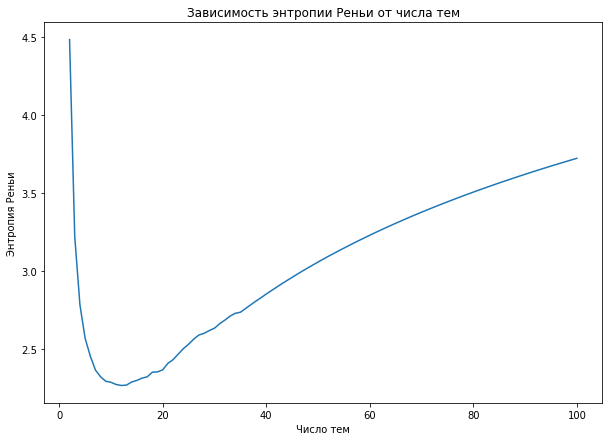

In [26]:
plt.figure(figsize=(10,7)) # задание размера фигуры
plt.plot(glob_clusters, glob_Renyi) # строим график
plt.title("Зависимость энтропии Реньи от числа тем") # название фигур
plt.xlabel("Число тем") # подпись по оси x
plt.ylabel("Энтропия Реньи") # подпись по оси y
plt.show() # показ фигуры

In [27]:
print(f"Минимальное значение энтропии Реньи ({min_Renyi}) было получено при числе тем {opt_topics_count}.")

Минимальное значение энтропии Реньи (2.2676427815674045) было получено при числе тем 12 


Посчитаем разбиение документов в датасете на заданное количество тем.

In [28]:
model = gibbslda.CGibbsLDA() # GLDAW модель
model.SetInputDocs(corpus) # загружаем исходные токенизированные текста в модель
model.SetParameters(alpha=0.1, beta=0.1, topics=opt_topics_count, niters=100, nitersave=100, ldamethod="embeddings", fixtopics=0, granwnd=0, out_dir=f"{DATA_DIR}{opt_topics_count}_topics/") # задаём параметры для GLDAW
model.SetEmbeddings(f"{EMBEDDING_DIR}words_in_docs.txt", emb_similars=30) # устанавливаем эмбеддинги 
model.StartCalculation() # запуск подсчёта матриц Ф и Θ при заданных параметрах

Documents count:  2553
Loading OK     
Calculating the Most Similar Words
Done. Words misses =  23768 / 64705
Iterations done:  100
    Documents ratio (Theta) =  21
    Words ratio (Phi) =  8


Загрузим получившиеся матрицы Phi (***Ф***) и Theta (***Θ***).

In [29]:
opt_topics = [f"Topic {i+1}" for i in range(opt_topics_count)] # список с названиями тем (i+1 чтобы нумерация шла с 1)

In [30]:
Ф_opt_columns = ["Word"] # список с столбцами для матрицы Ф, сначала в нём только столбец "Word"
Ф_opt_columns.extend(opt_topics) # расширяем список столбцов, добавляя элементы "Topic i" из генератора
Ф_opt = pd.read_csv(f"{DATA_DIR}{opt_topics_count}_topics/phi100.csv", sep=";", encoding="windows-1251", index_col=False, names=Ф_opt_columns) # считывание данных в формате csv, разделённых с помощью символа sep, закодированных в encoding, без колонки индексов в файле (index_col=False) и с кастомными названиями колонок (names)
Ф_opt # подсчитанная матрица Phi

,Word,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12
0,able,0.00024,0.00120,0.00060,0.00117,0.00030,0.00012,0.00043,0.00054,0.00073,0.00044,0.00040,0.00000
1,acceptable,0.00001,0.00012,0.00007,0.00000,0.00005,0.00001,0.00000,0.00000,0.00001,0.00003,0.00001,0.00020
2,accredit,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000
3,accreditation,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00004,0.00000,0.00000,0.00000,0.00000
4,added,0.00078,0.00000,0.00077,0.00000,0.00053,0.00002,0.00053,0.00140,0.00121,0.00079,0.00061,0.00008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64700,thawley,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
64701,transportable,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
64702,trashy,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
64703,vaccinecovid,0.00000,0.00001,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [31]:
Θ_opt_columns = ["Doc"] # список с столбцами для матрицы Θ, сначала в нём только столбец "Doc"
Θ_opt_columns.extend(opt_topics) # расширяем список столбцов, добавляя элементы "Topic i" из генератора
Θ_opt = pd.read_csv(f"{DATA_DIR}{opt_topics_count}_topics/theta100.csv", sep=";", encoding="windows-1251", index_col=0, names=Θ_opt_columns) # считывание данных в формате csv, разделённых с помощью символа sep, закодированных в encoding, с колонкой индексов в файле (index_col=0 — в качестве индексов будет идти первое значение) и с кастомными названиями колонок (names)
Θ_opt # подсчитанная матрица Theta

,Doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12
1,russia ha expelled dutch reporter newspaper ha...,0.00028,0.00870,0.09012,0.00590,0.00028,0.02555,0.00309,0.82285,0.00028,0.00028,0.01993,0.02274
2,largest important event mathematical calendar ...,0.00036,0.00036,0.00036,0.62400,0.00036,0.29212,0.00036,0.00036,0.00036,0.00036,0.08060,0.00036
3,earlier today set three question russian math ...,0.00028,0.00028,0.00028,0.68046,0.00028,0.22238,0.00028,0.00305,0.05580,0.00028,0.00028,0.03637
4,labour ha asked conservative check party ha ma...,0.01161,0.00023,0.89048,0.00023,0.00023,0.01617,0.00023,0.07536,0.00250,0.00250,0.00023,0.00023
5,russia ha hosted high profile international ta...,0.17872,0.01214,0.00024,0.00262,0.00024,0.03832,0.00024,0.71656,0.05021,0.00024,0.00024,0.00024
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549,joan e greve senate leader chuck schumer ha an...,0.02605,0.00003,0.00003,0.01922,0.00003,0.00003,0.00686,0.00524,0.08295,0.85949,0.00003,0.00003
2550,closing blog starting fresh australia health m...,0.01249,0.21110,0.00528,0.00003,0.00003,0.00003,0.00003,0.00003,0.76268,0.00036,0.00790,0.00003
2551,weve launched new blog link head latest hotel ...,0.03356,0.01468,0.02542,0.00850,0.01110,0.00003,0.01631,0.00003,0.85610,0.03388,0.00036,0.00003
2552,liveblog ha closed coverage coronavirus pandem...,0.04417,0.03422,0.00003,0.00003,0.00003,0.00103,0.00899,0.00601,0.86954,0.03588,0.00003,0.00003


## Соответствие слов/документов темам 

Нахождение топ-30 слов для каждой темы.

In [32]:
def show_important_words(Ф: pd.DataFrame, columns: list, n_words: int=30) -> pd.DataFrame:
    """
    Функция для определения самых важных слов в топике.\n
    Parameters:
        * Ф: матрица Phi (важности слов для тем), должна включать столбец "Word" (при использовании GLDAW модели матрица Phi уже идёт в нужном формате)
        * columns: список тем, для которых нужно определить слова с наибольшим вкладом
        * n_words: сколько слов с наибольшим вкладом искать для каждой темы\n
    Returns:
        * pd.DataFrame: матрица вида топ n слов для каждой темы
    """
    top_words_by_topics = pd.DataFrame(index=[f"Word {i+1}" for i in range(n_words)]) # создаём пустой pd.DataFrame, в котором есть только индексы под нужное число слов (колонок пока нет)
    for topic in columns: # идём по переданным столбцам (темам)
        Ф = Ф.sort_values(by=topic, ascending=False) # сортируем все элементы (строки) в pd.DataFrame в соответствии со значением в колонке by (ascending=False — в порядке уменьшения)
        top_words_by_topics[topic] = Ф["Word"][:n_words].values + " — " + Ф[topic][:n_words].astype(str).values # добавляем новую колонку в созданный pd.DataFrame, как объединение первых n_words значений отсортированных столбцов "Word" и "Topic i" из матрицы Phi

    return top_words_by_topics

In [33]:
top_words_by_topics = show_important_words(Ф_opt.copy(), opt_topics) # выводим важные для тем слова 
top_words_by_topics

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12
Word 1,ha — 0.01214,australia — 0.0166,ha — 0.01129,ha — 0.01041,climate — 0.02135,year — 0.008,ha — 0.01118,ha — 0.01178,covid — 0.01715,trump — 0.01418,game — 0.0104,song — 0.00412
Word 2,china — 0.01122,ha — 0.01393,government — 0.01056,one — 0.00778,country — 0.01288,one — 0.0066,price — 0.01115,russian — 0.00901,vaccine — 0.01578,biden — 0.01403,team — 0.01002,bird — 0.00394
Word 3,eu — 0.00761,australian — 0.00945,johnson — 0.00855,like — 0.00744,world — 0.01015,world — 0.00568,year — 0.00959,afghanistan — 0.00863,ha — 0.01469,president — 0.00947,final — 0.00982,music — 0.00387
Word 4,russia — 0.00732,government — 0.00723,company — 0.00609,time — 0.00647,emission — 0.00971,russia — 0.00471,uk — 0.00853,russia — 0.00853,people — 0.01014,house — 0.00928,min — 0.00656,film — 0.00343
Word 5,would — 0.00692,people — 0.00698,uk — 0.00598,first — 0.00633,ha — 0.00795,life — 0.00455,market — 0.0083,taliban — 0.00763,case — 0.00988,ha — 0.00837,medal — 0.00595,show — 0.00335
Word 6,country — 0.00687,new — 0.00694,would — 0.00566,set — 0.00597,cop — 0.00759,book — 0.00446,month — 0.00661,military — 0.00753,country — 0.00984,republican — 0.00771,gold — 0.00593,west — 0.00304
Word 7,foreign — 0.00524,day — 0.00461,party — 0.00563,think — 0.0059,global — 0.00745,time — 0.00436,energy — 0.0064,people — 0.00751,health — 0.00958,joe — 0.00594,ha — 0.00582,animal — 0.0027
Word 8,nuclear — 0.00478,today — 0.00458,minister — 0.00551,get — 0.00588,change — 0.00642,people — 0.00419,supply — 0.00588,country — 0.00737,new — 0.00811,white — 0.00593,goal — 0.0056,ranger — 0.00244
Word 9,biden — 0.00472,state — 0.0044,mp — 0.00518,back — 0.00571,year — 0.00634,ha — 0.0041,also — 0.00541,putin — 0.00551,coronavirus — 0.00778,state — 0.00564,time — 0.00549,series — 0.00241
Word 10,european — 0.00466,year — 0.00407,labour — 0.00469,would — 0.00529,carbon — 0.00555,new — 0.00391,rate — 0.00484,afghan — 0.00545,death — 0.00693,american — 0.00557,men — 0.00534,artist — 0.00241


Определение самых вероятных тем для документов.

In [34]:
Θ_values = Θ_opt.values[:,1:] # значения матрицы Θ ([:,1:] — все строки, но без колонки "Doc", что имеет первый индекс)
dominant_topic = np.argmax(Θ_values, axis=1) + 1 # ищем номер (индекс) самой вероятной темы для каждого документа (+1 из-за нумерации тем с единицы и так как нулевая колонка — "Doc") (axis=1 — argmax для строки)
Θ_opt["dominant_topic"] = dominant_topic # добавляем новую колонку в pd.DataFrame с посчитанными значениями самых вероятных тем


# Стилизация
def make_green_text(series):
    colors = np.full(shape=len(series), fill_value="color: gray", dtype=object) # создаём матрицу, заполненную значением цвета для всех элементов в pd.Series (dtype=object — чтобы не было лимита на длину строки)
    colors[series.iloc[-1]] = "color: green" # последний столбец ("dominant_topic") теперь содержит номер доминантного топика, поэтому по нему окрашиваем нужный топик в зелёный
    return colors

def make_bold(series): 
    bold = np.full(shape=len(series), fill_value="font-weight: 400", dtype=object) # создаём матрицу, заполненную значением толщины текста для всех элементов в pd.Series (dtype=object — чтобы не было лимита на длину строки)
    bold[series.iloc[-1]] = "font-weight: 700" # последний столбец ("dominant_topic") теперь содержит номер доминантного топика, поэтому по нему изменяем толщину нужного топика на 700
    return bold

# def make_green_text(val):
#     color = 'green' if (type(val) == float and val > .1) else 'black'
#     return f"color: {color}"

# def make_bold(val):
#     weight = 700 if (type(val) == float and val > .1) else 400
#     return f"font-weight: {weight}"


Θ_opt = Θ_opt.head(20) # берём первый 20 элементов из pd.DataFrame
Θ_opt = Θ_opt.style.apply(make_green_text, axis=1).apply(make_bold, axis=1) # добавляем стили для строк (axis=1), при этом объект становится pandas.io.formats.style.Styler из pd.DataFrame
# Θ_opt = Θ_opt.style.map(make_green_text).map(make_bold) # добавляем стили для элементов (cell), при этом объект становится pandas.io.formats.style.Styler из pd.DataFrame
# в .map передаются элементы pd.Dataframe поштучно (значение cell), тогда как в .apply сразу pd.Series (строка или столбец в зависимости от axis)

Θ_opt

,Doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,dominant_topic
1,russia ha expelled dutch reporter newspaper ha mos,0.000280,0.008700,0.090120,0.005900,0.000280,0.025550,0.003090,0.822850,0.000280,0.000280,0.019930,0.022740,8
2,largest important event mathematical calendar take,0.000360,0.000360,0.000360,0.624000,0.000360,0.292120,0.000360,0.000360,0.000360,0.000360,0.080600,0.000360,4
3,earlier today set three question russian math comp,0.000280,0.000280,0.000280,0.680460,0.000280,0.222380,0.000280,0.003050,0.055800,0.000280,0.000280,0.036370,4
4,labour ha asked conservative check party ha made d,0.011610,0.000230,0.890480,0.000230,0.000230,0.016170,0.000230,0.075360,0.002500,0.002500,0.000230,0.000230,3
5,russia ha hosted high profile international talk a,0.178720,0.012140,0.000240,0.002620,0.000240,0.038320,0.000240,0.716560,0.050210,0.000240,0.000240,0.000240,8
6,russia may dissolve memorial country premier human,0.000170,0.003640,0.078140,0.000170,0.003640,0.391720,0.000170,0.521660,0.000170,0.000170,0.000170,0.000170,8
7,russia ha accused west building force border well,0.323970,0.000360,0.000360,0.000360,0.000360,0.000360,0.000360,0.672480,0.000360,0.000360,0.000360,0.000360,8
8,germany new chancellor faced pressure fellow leade,0.753750,0.000260,0.000260,0.000260,0.000260,0.000260,0.000260,0.243660,0.000260,0.000260,0.000260,0.000260,1
9,nato secretary general jens stoltenberg ha caution,0.455400,0.007090,0.000230,0.000230,0.009380,0.000230,0.000230,0.526300,0.000230,0.000230,0.000230,0.000230,8
10,good morning malcolm turnbull welcome climate focu,0.047670,0.453080,0.132760,0.057680,0.050180,0.161540,0.031410,0.012640,0.030160,0.005130,0.017640,0.000130,2


## Оценка качества тематического разбиения 

Далее просто приведён список возможных вариантов для оценки качества найденного тематического разбиения, большинство из указаных методов реализованы в библиотеке gensim и sklearn.

Дополнительную информацию можно найти в папке `./info/` или в лекции 7.

### 1) Coherence (Когерентность)

Тема называется когерентной (согласованной), если термины, наиболее частые в данной теме, 
неслучайно часто совместно встречаются рядом в документах коллекции. 
Когерентность может оцениваться по сторонней коллекции (например, по Википедии), 
либо по той же коллекции, по которой строится модель.
Для оценивания когерентности использовалась поточечная взаимная информация (pointwise mutual information, PMI). 
Однако она может сильно меняться от запуска к запуску.

<img src="./images/coherence.png" alt="Coherence"/>

### 2) Logarithm of likelihood (логарифм правдоподобия)

Чем выше значение логарифмической вероятности, тем лучше модель соответствует набору данных.
Значение логарифмического правдоподобия для данной модели может варьироваться от отрицательной бесконечности до положительной бесконечности. Фактическое значение логарифмического правдоподобия для данной модели в большинстве случаев не имеет смысла, но **оно полезно для сравнения двух или более моделей** (и только если у них одинаковое количество признаков).

<img src="./images/log_likelihood.png" alt="Log-likelihood"/>

### 3) Perplexity (перплексия)

Перплексия — мера того, насколько хорошо тематическая модель предсказывает на новых данных. Она отражает способность модели к обобщению (на сколько будет размыта тема у нового документа).

<img src="./images/perplexity.png" alt="Perplexity"/>

### 4) Topic stability (Kullback — Leibler Distance)

Расстояние Кульбака — Лейблера используется для определения схожести между двумя распределениями (расстояния между ними). Чем оно ближе к нулю, тем распределения более схожи. 
Нормализованная же мера воспринимается иначе, чем ближе к 1 — тем сильнее распределения похожи.

<img src="./images/stability_1.png" alt="Kullback — Leibler Distance 1"/>
<img src="./images/stability_2.png" alt="Kullback — Leibler Distance 2"/>